In [109]:
import os
import gc
import time
import pickle
import datetime
import pandas as pd
import numpy as np
import dask.dataframe as dd
from dask import delayed, compute
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import preprocessing, metrics
import lightgbm as lgb
from textblob import TextBlob

path = "F:\\Pratik\\LearningZone\\Competitions\\Avito_Demand_Prediction_Challenge"
os.chdir(path)

In [8]:
train_df = pd.read_csv('train_translated.csv', parse_dates=['activation_date'])
test_df = pd.read_csv('test_translated.csv', parse_dates=['activation_date'])

In [75]:
total_df = pd.read_csv('total_translated.csv', parse_dates=['activation_date'])

In [9]:
train_df['dow'] = train_df['activation_date'].dt.weekday
test_df['dow'] = test_df['activation_date'].dt.weekday

In [76]:
total_df['dow'] = total_df['activation_date'].dt.weekday

In [ ]:
train_df.head()

In [77]:
cat_vars = ["en_region", "en_city", "en_parent_category_name", "en_category_name", "user_type", "en_param1", "en_param2", "en_param3"]

In [11]:
def label_encoding(train_data, categorical_feature_names):
    le = preprocessing.LabelEncoder() # Defining Label Encoder
    train_cat_features = np.array(train_data[categorical_feature_names])
    train_data_array = le.fit_transform(train_cat_features[:,0])
    for i in range(1,train_cat_features.shape[1]):
        train_data_array = np.column_stack((train_data_array, le.fit_transform(train_cat_features[:,i])))
        
    train_cat_data_df = pd.DataFrame(train_data_array, columns=categorical_feature_names)
    return train_cat_data_df[categorical_feature_names]

In [78]:
total_df[['en_param1','en_param2','en_param3']].fillna('Missing', inplace=True)

C:\Program Files\Anaconda\lib\site-packages\pandas\core\frame.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [13]:
train_df[['en_param1','en_param2','en_param3']].fillna('Missing', inplace=True)
test_df[['en_param1','en_param2','en_param3']].fillna('Missing', inplace=True)

C:\Program Files\Anaconda\lib\site-packages\pandas\core\frame.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [79]:
total_df['en_param1'] = total_df['en_param1'].map(str)
total_df['en_param2'] = total_df['en_param2'].map(str)
total_df['en_param3'] = total_df['en_param3'].map(str)

In [14]:
train_df['en_param1'] = train_df['en_param1'].map(str)
train_df['en_param2'] = train_df['en_param2'].map(str)
train_df['en_param3'] = train_df['en_param3'].map(str)

In [15]:
test_df['en_param1'] = test_df['en_param1'].map(str)
test_df['en_param2'] = test_df['en_param2'].map(str)
test_df['en_param3'] = test_df['en_param3'].map(str)

In [80]:
Catg_Var_LE = label_encoding(total_df, cat_vars)

In [16]:
Catg_Var_LE_train = label_encoding(train_df,cat_vars)
Catg_Var_LE_test = label_encoding(test_df,cat_vars)

In [81]:
# Dropping the rows on which One-Hot Encoding has been performed
total_df = total_df.drop(Catg_Var_LE.columns, axis=1)
# Concating the rows converted using One-Hot Encoding to other columns:
total_df = pd.concat([total_df,Catg_Var_LE], axis=1)

In [17]:
# Dropping the rows on which One-Hot Encoding has been performed
train_df = train_df.drop(Catg_Var_LE_train.columns, axis=1)
# Concating the rows converted using One-Hot Encoding to other columns:
train_df = pd.concat([train_df,Catg_Var_LE_train], axis=1)

In [18]:
# Dropping the rows on which One-Hot Encoding has been performed
test_df = test_df.drop(Catg_Var_LE_test.columns, axis=1)
# Concating the rows converted using One-Hot Encoding to other columns:
test_df = pd.concat([test_df,Catg_Var_LE_test], axis=1)

In [82]:
train_df = total_df[total_df['set'] == 'train']
test_df = total_df[total_df['set'] == 'test']

In [83]:
total_df[total_df['set'] == 'test']

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,price_new,dow,en_region,en_city,en_parent_category_name,en_category_name,user_type,en_param1,en_param2,en_param3
1503424,6544e41a8817,dbe73ad6e4b5,Волгоградская область,Волгоград,Личные вещи,Детская одежда и обувь,Для мальчиков,Обувь,25,Отдам бесплатно,...,307410.420914,1,25,1511,5,9,1,131,89,74
1503425,65b9484d670f,2e11806abe57,Свердловская область,Нижняя Тура,Хобби и отдых,Велосипеды,Дорожные,NaN,NaN,Продам велосипед,...,3000.000000,6,19,730,4,4,1,271,273,1250
1503426,8bab230b2ecd,0b850bbebb10,Новосибирская область,Бердск,Бытовая электроника,Аудио и видео,Телевизоры и проекторы,NaN,NaN,BBK,...,15000.000000,0,11,142,1,3,1,315,273,1250
1503427,8e348601fefc,5f1d5c3ce0da,Саратовская область,Саратов,Для дома и дачи,Бытовая техника,Для кухни,Вытяжки,NaN,Вытяжка Jetair 60,...,4500.000000,0,17,1145,3,1,1,134,113,1250
1503428,8bd2fe400b89,23e2d97bfc7f,Оренбургская область,Бузулук,Личные вещи,Товары для детей и игрушки,Детские коляски,NaN,NaN,Коляска зима-лето,...,4900.000000,5,13,216,5,22,1,20,273,1250
1503429,c63dbd6c657f,c2a632af2602,Ростовская область,Ростов-на-Дону,Для дома и дачи,Ремонт и строительство,Окна и балконы,NaN,NaN,Стекла для пластиковых окон,...,500.000000,2,15,1125,3,38,1,348,273,1250
1503430,6d1a410df86e,b239811ad530,Оренбургская область,Оренбург,Бытовая электроника,Ноутбуки,NaN,NaN,NaN,Ноутбук Lenovo Ideapad 300-15Ibr арт.14899,...,20990.000000,0,13,967,1,27,2,358,273,1250
1503431,e8d3e7922b80,d85fa02e6341,Калининградская область,Калининград,Бытовая электроника,Телефоны,Аксессуары,Чехлы и плёнки,NaN,Nillkin Phenom для Apple iPhone,...,990.000000,1,5,512,1,33,2,3,62,1250
1503432,2bc1ab208462,ae6586719bec,Новосибирская область,Новосибирск,Бытовая электроника,Товары для компьютера,Флэшки и карты памяти,NaN,NaN,Флешка USB 32Gb smartbuy,...,1200.000000,1,11,924,1,13,0,339,273,1250
1503433,7e05d77a9181,30ad26d633ef,Свердловская область,Полевской,Личные вещи,Детская одежда и обувь,Для девочек,Обувь,23,Ботинки,...,400.000000,2,19,1044,5,9,1,132,89,64


In [84]:
target = 'deal_probability'
predictors = ['dow', 'en_region', 'en_city',
       'en_parent_category_name', 'en_category_name', 'user_type', 'en_param1',
       'en_param2', 'en_param3','price_new']

In [85]:
# Splitting the data for model training#
dev_X = train_df.iloc[:-200000,:]
val_X = train_df.iloc[-200000:,:]

In [117]:
def run_lgb(train_X, val_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 40,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X[predictors].values, label=train_X[target].values)
    lgval = lgb.Dataset(val_X[predictors].values, label=val_X[target].values)
    evals_result = {}
    model = lgb.train(params, lgtrain, 5000, valid_sets=[lgtrain, lgval], early_stopping_rounds=100, verbose_eval=20, evals_result=evals_result)
    
    #pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return model, evals_result

In [99]:
params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 30,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }

In [ ]:
num_leaves = [20, 25, 30, 35, 40]
learning_rate = [0.01, 0.05, 0.1, 0.15, 0.2]
bst_results = []
for num_lv in num_leaves:
    for lr in learning_rate:
        new_params = {"num_leaves" : num_lv, "learning_rate" : lr}
        params.update(new_params)
        lgtrain = lgb.Dataset(train_X[predictors].values, label=train_X[target].values)
        lgval = lgb.Dataset(val_X[predictors].values, label=val_X[target].values)
        evals_result = {}
        model = lgb.train(params, lgtrain, 1000, valid_sets=[lgtrain, lgval], early_stopping_rounds=100, verbose_eval=20, evals_result=evals_result)
        bst_results.append(params, )

In [107]:
model = lgb.LGBMRegressor(objective="regression",
        metric = "rmse",
        num_leaves = 30,
        learning_rate = 0.1,
        bagging_fraction = 0.7,
        feature_fraction = 0.7,
        bagging_frequency = 5,
        bagging_seed = 2018,
        verbosity = -1)

In [108]:
params_opt = {'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2], "num_leaves" : [20, 25, 30, 35, 40]}

In [110]:
gridSearchCV = GridSearchCV(estimator = model, 
    param_grid = params_opt, verbose=1)

In [111]:
gridSearchCV.fit(train_df[predictors],train_df[target])

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 13.3min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LGBMRegressor(bagging_fraction=0.7, bagging_frequency=5, bagging_seed=2018,
       boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       feature_fraction=0.7, learning_rate=0.1, max_depth=-1,
       metric='rmse', min_child_samples=20, min_child_weight=0.001,
       min_spl...da=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1, verbosity=-1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2], 'num_leaves': [20, 25, 30, 35, 40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [114]:
gridSearchCV.grid_scores_

C:\Program Files\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.13209, std: 0.00041, params: {'learning_rate': 0.01, 'num_leaves': 20},
 mean: 0.13629, std: 0.00032, params: {'learning_rate': 0.01, 'num_leaves': 25},
 mean: 0.13980, std: 0.00031, params: {'learning_rate': 0.01, 'num_leaves': 30},
 mean: 0.14259, std: 0.00033, params: {'learning_rate': 0.01, 'num_leaves': 35},
 mean: 0.14508, std: 0.00032, params: {'learning_rate': 0.01, 'num_leaves': 40},
 mean: 0.18440, std: 0.00095, params: {'learning_rate': 0.05, 'num_leaves': 20},
 mean: 0.18848, std: 0.00082, params: {'learning_rate': 0.05, 'num_leaves': 25},
 mean: 0.19178, std: 0.00084, params: {'learning_rate': 0.05, 'num_leaves': 30},
 mean: 0.19479, std: 0.00109, params: {'learning_rate': 0.05, 'num_leaves': 35},
 mean: 0.19652, std: 0.00107, params: {'learning_rate': 0.05, 'num_leaves': 40},
 mean: 0.19442, std: 0.00125, params: {'learning_rate': 0.1, 'num_leaves': 20},
 mean: 0.19837, std: 0.00145, params: {'learning_rate': 0.1, 'num_leaves': 25},
 mean: 0.20112, std: 0.00129, 

In [118]:
model, result = run_lgb(dev_X, val_X)

Training until validation scores don't improve for 100 rounds.
[20]	training's rmse: 0.235874	valid_1's rmse: 0.236164
[40]	training's rmse: 0.233528	valid_1's rmse: 0.233838
[60]	training's rmse: 0.232553	valid_1's rmse: 0.232909
[80]	training's rmse: 0.231928	valid_1's rmse: 0.232326
[100]	training's rmse: 0.23145	valid_1's rmse: 0.231907
[120]	training's rmse: 0.231133	valid_1's rmse: 0.231645
[140]	training's rmse: 0.23081	valid_1's rmse: 0.231372
[160]	training's rmse: 0.23058	valid_1's rmse: 0.231213
[180]	training's rmse: 0.230325	valid_1's rmse: 0.23102
[200]	training's rmse: 0.230132	valid_1's rmse: 0.230926
[220]	training's rmse: 0.229936	valid_1's rmse: 0.230789
[240]	training's rmse: 0.229731	valid_1's rmse: 0.230661
[260]	training's rmse: 0.229565	valid_1's rmse: 0.230568
[280]	training's rmse: 0.229403	valid_1's rmse: 0.230487
[300]	training's rmse: 0.229257	valid_1's rmse: 0.230412
[320]	training's rmse: 0.229123	valid_1's rmse: 0.230344
[340]	training's rmse: 0.228977	v

In [119]:
test_df['deal_probability'] = model.predict(test_df[predictors])

C:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [122]:
test_df[['item_id','deal_probability']].to_csv('base_submission_total_numleaves40.csv', index=False)

In [35]:
len(test_df)

508438

In [121]:
test_df.deal_probability[test_df['deal_probability'] < 0] = 0

C:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Program Files\Anaconda\lib\site-packages\pandas\core\generic.py:5984: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\Program Files\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2910: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns

In [30]:
import kaggle

In [ ]:
!kaggle competitions submit -c avito-demand-prediction -f base_submission_total_numleaves40.csv -m "Increasing number of leaves"

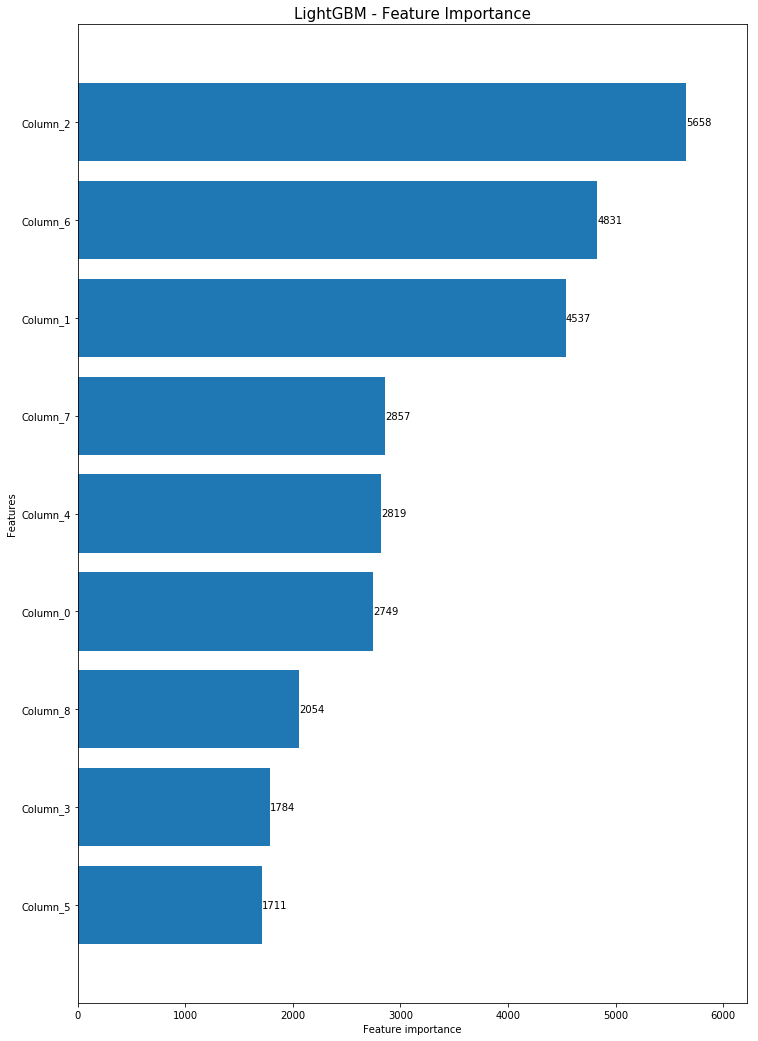

In [23]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()